In [307]:
from collections import defaultdict
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [202]:
ISLAND_SIZE_CUTOFF_KM2 = 10
def sqm_to_deg(sqm):
    return (1.0 / (111.32 ** 2)) * sqm
ISLAND_SIZE_CUTOFF_DEG2 = sqm_to_deg(ISLAND_SIZE_CUTOFF_KM2)

In [207]:
g = nx.read_gpickle(r'C:\Users\kasih_000\PycharmProjects\abm\data\islands.gpickle')
to_aus = g[2591].keys()
from_sunda = g[1919].keys()
to_del = [node for node, data in g.nodes_iter(data=True) if data['area'] < ISLAND_SIZE_CUTOFF_DEG2]

In [208]:
can_see = {node: {
                    n: {
                        'ab': d['area'],
                        'ba': g[n][node]['area'],
                        'd': np.sqrt((d['a'][0] - d['b'][0]) ** 2 + (d['a'][1] - d['b'][1]) ** 2)
                    } for n, d in g[node].iteritems()
                    }
             for node, data in g.nodes_iter(data=True)}

In [209]:
g.remove_edges_from((x, 1919) for x in from_sunda)
g.remove_edges_from((2591, x) for x in to_aus)
g.remove_nodes_from(to_del)

In [210]:
def normalise(g, node, can_see, norm=False):
    """
    :param can_see:
    :type can_see: dict[int, float]
    :return:
    :rtype: (numpy.ndarray, numpy.ndarray)
    """
    if len(can_see) > 0:
        prob_dict = {i: (x['ab'] / g.node[node]['area']) * (x['ba'] / x['d']) for i, x in can_see.iteritems() if i in g[node]}
        probs = np.array(prob_dict.values())
        if norm:
            probs = probs / probs.sum()
        islands = np.array(prob_dict.keys(), dtype=np.int32)
        return dict(zip(islands, probs))
    else:
        return {}

In [287]:
for node in g.nodes_iter():
    p = normalise(g, node, islands[node], True)
    for other_node, prob in p.iteritems():
        g.edge[node][other_node]['weight'] = prob

In [288]:
x = nx.algorithms.tree.Edmonds(G, 1919)

In [289]:
optimum = x.find_optimum(style='arborescence')

In [290]:
optimum[374]

{367: {'weight': 1.0}, 379: {'weight': 0.2}, 380: {'weight': 0.25}}

In [291]:
gateways = {}
for gw in (1,2,3):
    with open(r'E:\Kasih\Dropbox\2. PNAS\GW{}.txt'.format(gw), 'rb') as f:
        header = f.readline()
        for line in f:
            gateways[int(line.split(',')[0])] = gw

In the arcgis interpreter:
    >>> with open(r'E:\Kasih\Dropbox\2. PNAS\island_locations.csv', 'w') as nf:
    ...     for fid, (x, y), area in SearchCursor("islands", ["OID@", "SHAPE@TRUECENTROID", "SHAPE@AREA"]):
    ...         nf.write('{},{},{},{}\n'.format(fid,x,y,area))


In [6]:
pos_dict = {}
area_dict = {}
with open(r'E:\Kasih\Dropbox\2. PNAS\island_locations.csv', 'r') as f:
    for line in f:
        fid, x, y, area = line.strip().split(',')
        pos_dict[int(fid)] = (float(x),float(y))
        area_dict[int(fid)] = float(area)

In [7]:
runs = {
    'all_demog': ['north', 'south', 'taiwan', 'palawan'],
    'north_demog': ['north'],
    'south_demog': ['south'],
    'taiwan_demog': ['taiwan'],
    'palawan_demog': ['palawan'],
    'taiwan_north_demog': ['taiwan', 'north'],
    'taiwan_palawan_demog': ['taiwan', 'palawan'],
    'south_north_demog': ['south', 'north'],
    'south_palawan_demog': ['south', 'palawan'],
    'north_palawan_demog': ['north', 'palawan'],
    'taiwan_south_demog': ['taiwan', 'south'],
    'north_oft': ['north'],
    'south_oft': ['south'],
    'taiwan_oft': ['taiwan'],
    'palawan_oft': ['palawan'],
}

In [8]:
labels = {
    'oft': 'ABM1 Aggregated',
    'demog': 'ABM2 Aggregated',
    'all_demog': 'ABM2: Sulawesi, Banda Arc, Taiwan, Palawan',
    'north_demog': 'ABM2: Sulawesi',
    'south_demog': 'ABM2: Banda Arc',
    'taiwan_demog': 'ABM2: Taiwan',
    'palawan_demog': 'ABM2: Palawan',
    'taiwan_north_demog': 'ABM2: Taiwan, Sulawesi',
    'taiwan_palawan_demog': 'ABM2: Taiwan, Palawan',
    'south_north_demog': 'ABM2: Banda Arc, Sulawesi',
    'south_palawan_demog': 'ABM2: Banda Arc, Palawan',
    'north_palawan_demog': 'ABM2: Sulawesi, Palawan',
    'taiwan_south_demog': 'ABM2: Taiwan, Banda Arc',
    'north_oft': 'ABM1: Sulawesi',
    'south_oft': 'ABM1: Banda Arc',
    'taiwan_oft': 'ABM1: Taiwan',
    'palawan_oft': 'ABM1: Palawan',
}

In [9]:
island_labels = {
    572: "Luzon (the Philippines)",
    936: "Palawan (Philippine land bridge)",
    1110: "Tawitawi (Philippine land bridge)",
    1077: "Mindanao (the Philippines)",
    1184: "Sangihe",
    1338: "Halmahera",
    1400: "Obi",
    1432: "Peleng",
    1445: "Taliabu",
    1523: "Buru",
    1529: "Seram",
    1660: "Sulawesi",
    1746: "Selayar",
    1757: "Paleo-island",
    1919: "Asia (Sunda)",
    1932: "Flores",
    1948: "Sumbawa",
    2068: "Paleo-island",
    2081: "Sumba",
    2088: "Timor",
    2173: "Rote",
    2180: "Sahul Shelf",
    2591: "Greater Australia (Sahul)",
}

In [18]:
l = []
bump_ons = 0
total = 0
total_traversals = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
l.append(('run_type', 'run_name', 'populations', 'population', 'entry_island', 'exit_island', 'gateway', 'path_length'))
for run, pops in runs.items():
    run_name, run_type = run.rsplit('_', 1)
    try:
        with open(r'C:\Users\kasih_000\PycharmProjects\abm\output\20161218_115935\{}\logs\times.txt'.format(run), 'r') as f:
            year_i = 0
            paths = set()
            traversals = set()
            header = f.readline()
            for line in f:
                total += 1
                pop, years, path = line.strip().split(',')
                year, island = zip(*[x.split('|') for x in path.split(':')])
                if int(year[-1]) < int(year_i):
                    paths = set()
                    traversals = set()
                year_i = year[-1]
                this_path = tuple(island)
                if this_path not in paths:
                    paths.add(this_path)
                    for i in range(len(island)-1):
                        t = tuple(island[i:i+2])
                        if t not in traversals:
                            traversals.add(t)
                            total_traversals[run_type][(int(t[0]), int(t[1]))] += 1
                            total_traversals[run][(int(t[0]), int(t[1]))] += 1
                    l.append((run_type, run_name, '|'.join(pops), pop.split('_')[0], int(island[1]), int(island[-2]), gateways[int(island[-2])], len(island)-2))
                else:
                    bump_ons += 1
    except IOError:
        continue
print('Bump ons: {}'.format(bump_ons))

Bump ons: 26768


In [65]:
def get_panda(runs):
    for run, pops in runs.items():
        run_name, run_type = run.rsplit('_', 1)
        try:
            with open(r'C:\Users\kasih_000\PycharmProjects\abm\output\20161218_115935\{}\logs\times.txt'.format(run), 'r') as f:
                run_counter = 0
                year_i = 0
                paths = set()
                header = f.readline()
                for line in f:
                    pop, years, path = line.strip().split(',')
                    year, island = zip(*[x.split('|') for x in path.split(':')])
                    if int(year[-1]) < int(year_i):
                        run_counter += 1
                        paths = set()
                    year_i = year[-1]
                    this_path = tuple(island)
                    if this_path not in paths:
                        paths.add(this_path)
                        for i in range(len(island)-1):
                            t = tuple(island[i:i+2])
                            yield {
                                'run_type': run_type,
                                'run_name': run_name, 
                                'populations': '|'.join(pops), 
                                'population': pop.split('_')[0], 
                                'from_island': int(t[0]), 
                                'to_island': int(t[1]),
                                'year': int(year[i+1]),
                                'iteration': run_counter,
                                'path': hash(this_path),
                                'gateway': gateways[int(island[-2])]
                            }
        except IOError:
            continue

In [66]:
get_panda(runs).next()

{'from_island': 1919,
 'gateway': 1,
 'iteration': 0,
 'path': -1093128171,
 'population': 'south',
 'populations': 'south',
 'run_name': 'south',
 'run_type': 'demog',
 'to_island': 1933,
 'year': 2}

In [67]:
df = pd.DataFrame.from_dict(get_panda(runs))

In [68]:
df.head()

,from_island,gateway,iteration,path,population,populations,run_name,run_type,to_island,year
0,1919,1,0,-1093128171,south,south,south,demog,1933,2
1,1933,1,0,-1093128171,south,south,south,demog,1948,50
2,1948,1,0,-1093128171,south,south,south,demog,1757,102
3,1757,1,0,-1093128171,south,south,south,demog,1660,152
4,1660,1,0,-1093128171,south,south,south,demog,1445,254


In [69]:
df = df.drop_duplicates(subset=['from_island', 'iteration', 'population', 'populations', 'run_name', 'run_type', 'to_island'])

In [70]:
df.path.unique().shape[0]

18517L

In [308]:
gateways_df = df[df['to_island'] == 2591]

In [309]:
gateways_df.head()

,from_island,gateway,iteration,path,population,populations,run_name,run_type,to_island,year
8,1529,1,0,-1093128171,south,south,south,demog,2591,324
16,2180,3,0,-893511601,south,south,south,demog,2591,328
24,1354,1,0,293282936,south,south,south,demog,2591,333
34,1347,1,0,1425967781,south,south,south,demog,2591,340
71,1299,1,0,-374217570,south,south,south,demog,2591,378


In [310]:
summary = gateways_df.groupby(['run_type', 'run_name', 'population', 'gateway'])['iteration'].count()

In [313]:
summary.to_frame()

iteration
run_type run_name       population gateway           
demog    all            north      1             2520
                                   2                2
                                   3               50
                        south      1                2
                                   3             1115
         north          north      1             2490
                                   2                1
                                   3              971
         north_palawan  north      1             2472
                                   3              996
         palawan        palawan    1              879
         south          south      1             2536
                                   3             1201
         south_north    north      1             2502
                                   3               69
                        south      1                3
                                   3             1061
         south_palawan  palawan    1              295
                        south      1             2401
                                   3             1179
         taiwan         taiwan     1              346
         taiwan_north   north      1             2458
                                   2                1
                                   3             1028
         taiwan_palawan palawan    1             1015
                        taiwan     1                5
         taiwan_south   south      1             2499
                                   3             1214
                        taiwan     1               66
oft      north          north      1             1437
         palawan        palawan    1                2
         south          south      1              626
                                   2                1
                                   3              215

In [90]:
summary.reset_index().groupby(['run_type', 'population', 'gateway'])['iteration'].sum().to_frame()

iteration
run_type population gateway           
demog    north      1            12442
                    2                4
                    3             3114
         palawan    1             2189
         south      1             7441
                    3             5770
         taiwan     1              417
oft      north      1             1437
         palawan    1                2
         south      1              626
                    2                1
                    3              215

In [36]:
gw = defaultdict(lambda: {1:1, 2:0, 3:0})
for run_type in total_traversals:
    for x, y in total_traversals[run_type].iteritems():
        if x[1] == 2591:
            gw[run_type][gateways[x[0]]] += y
# {x[0]: y for x, y in total_traversals['all_demog'].iteritems() if x[1] == 2591}

In [37]:
gw

defaultdict(<function __main__.<lambda>>,
            {'all_demog': {1: 2521, 2: 2, 3: 1165},
             'demog': {1: 22250, 2: 4, 3: 8884},
             'north_demog': {1: 2491, 2: 1, 3: 971},
             'north_oft': {1: 1438, 2: 0, 3: 0},
             'north_palawan_demog': {1: 2473, 2: 0, 3: 996},
             'oft': {1: 2066, 2: 1, 3: 215},
             'palawan_demog': {1: 880, 2: 0, 3: 0},
             'palawan_oft': {1: 3, 2: 0, 3: 0},
             'south_demog': {1: 2537, 2: 0, 3: 1201},
             'south_north_demog': {1: 2504, 2: 0, 3: 1130},
             'south_oft': {1: 627, 2: 1, 3: 215},
             'south_palawan_demog': {1: 2503, 2: 0, 3: 1179},
             'taiwan_demog': {1: 347, 2: 0, 3: 0},
             'taiwan_north_demog': {1: 2459, 2: 1, 3: 1028},
             'taiwan_palawan_demog': {1: 1021, 2: 0, 3: 0},
             'taiwan_south_demog': {1: 2524, 2: 0, 3: 1214}})

In [11]:
networks = {}
for network in total_traversals:
    G = nx.DiGraph()
    for (a,b), t in total_traversals[network].iteritems():
        a, b = int(a), int(b)
        G.add_edge(a, b, {'weight': 1.0/int(t), 'traversals': int(t)})
    networks[network] = G

In [250]:
R = nx.algorithms.flow.edmonds_karp(g, 1919, 2591, capacity='weight')

In [292]:
R = nx.algorithms.flow.edmonds_karp(g, 1933, 2591, capacity='weight')

In [293]:
tmp = {x: {'gateway': gateways[x], 'flow': -c['flow']} for x, c in R[2591].iteritems() if c['flow'] < 0}

In [294]:
{x: c for x, c in R[1919].iteritems() if c['flow'] > 0}

{}

In [295]:
d = {1:0.0, 2:0.0, 3:0.0}
for k,v in tmp.iteritems():
    d[v['gateway']] += v['flow']
d

{1: 0.063561558661371198, 2: 0.0, 3: 0.0017208281746538229}

In [296]:
d[1] / (d[1] + d[3])

0.9736402380786694

In [297]:
edges = [(x[0], x[1]) for x in R.edges_iter(data=True) if x[2]['flow'] > 0]
nodelist = list({x for y in edges for x in y})

In [304]:
def graph_flow(g, origin, name, sink=2591):
    R = nx.algorithms.flow.edmonds_karp(g, origin, sink, capacity='weight')
    edges = [(x[0], x[1]) for x in R.edges_iter(data=True) if x[2]['flow'] > 0]
    nodelist = list({x for y in edges for x in y})
    sb.set_context("paper")
    cmap='rainbow'
    fig = plt.figure(num=None, figsize=(12, 12))
    bc = nx.betweenness_centrality(R, weight='flow')
    min_bc, max_bc = min(bc.itervalues()), max(bc.itervalues())
    mp = (max_bc - min_bc) / 4.0

    node_colour = [(1,0,0) if x in {origin, sink} else (1,1,1) for x in nodelist]
    size = [np.log(area_dict[int(x)]) * 20 + 100 for x in nodelist]
    weights = [np.log(R[u][v]['capacity']) for u,v in edges]
    nx.draw_networkx(R, pos=pos_dict, nodelist=nodelist, node_size=size, with_labels=True, node_color=node_colour,
                     edgelist=edges, arrows=False, labels=island_labels, font_size='small',)
    plt.title(name)
    plt.xlabel('Longitude', fontsize='large')
    plt.ylabel('Latitude', fontsize='large')
    plt.savefig(r'E:\Kasih\Dropbox\2. PNAS\sensitivity_{}.pdf'.format(name))

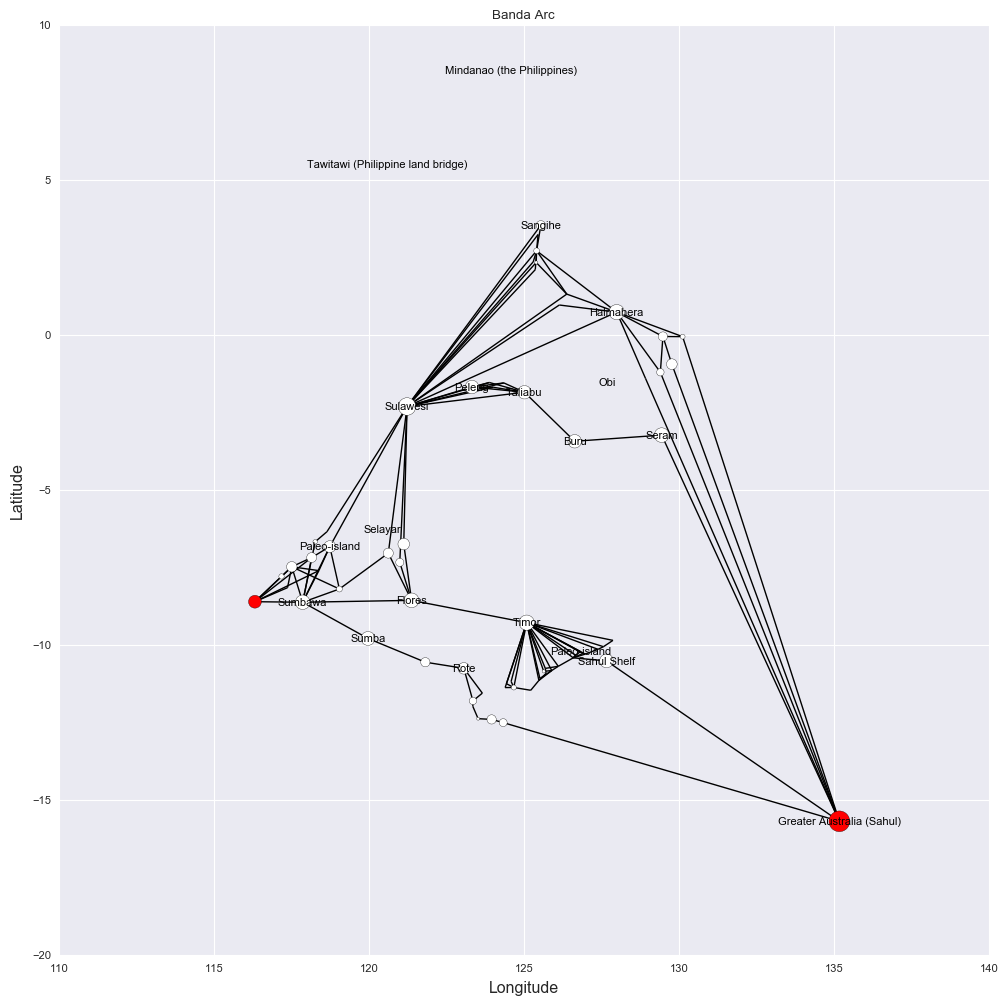

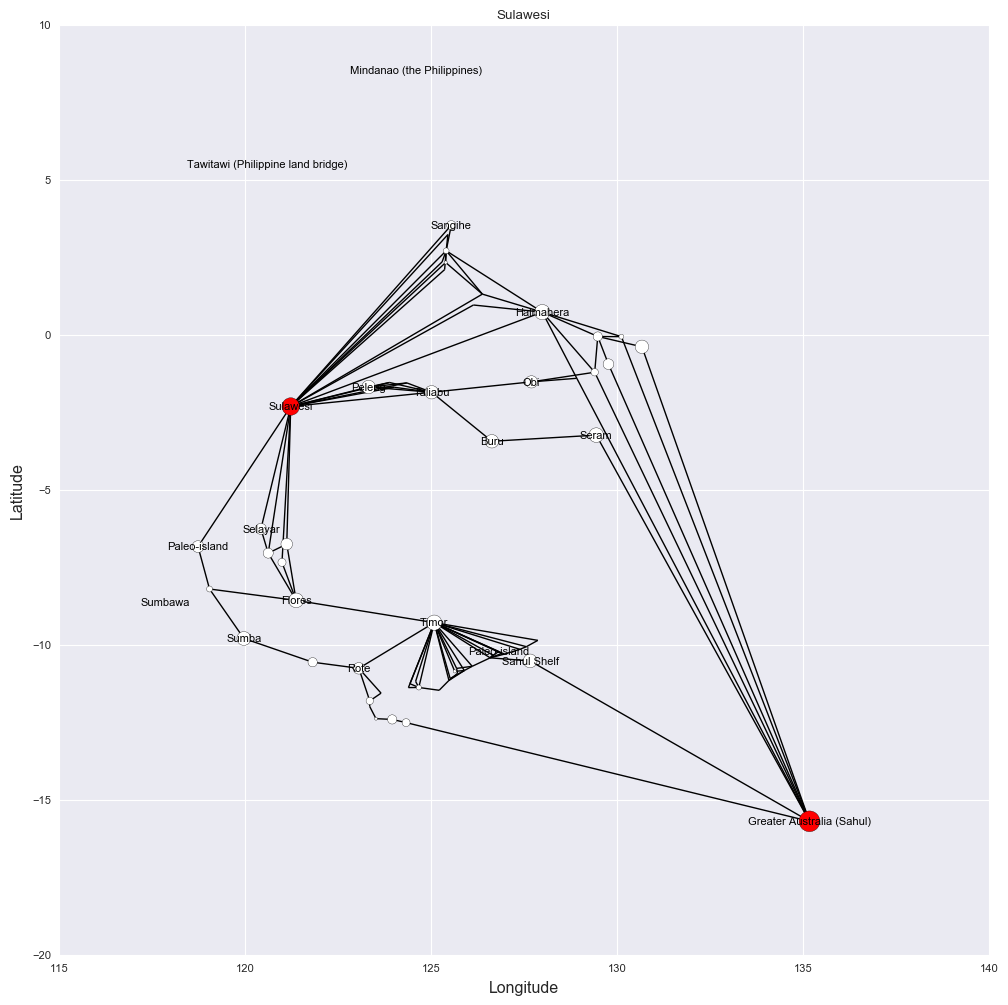

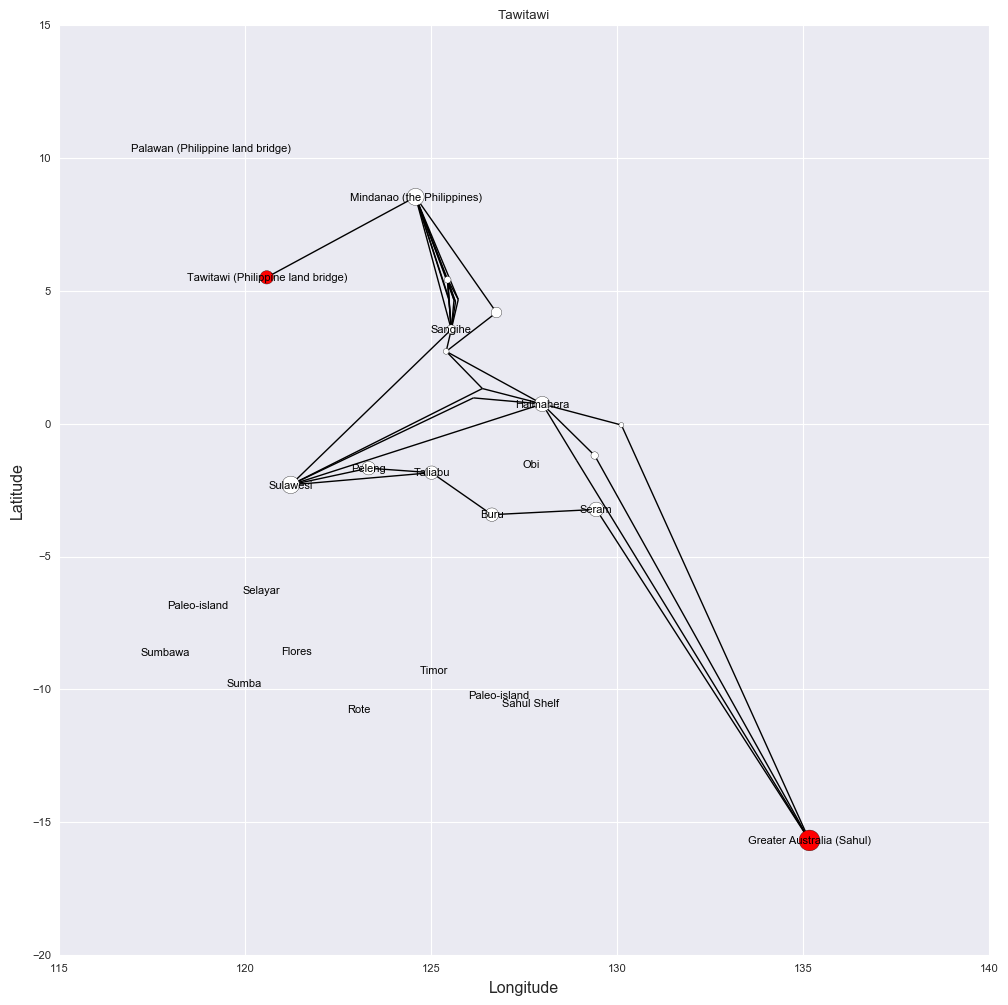

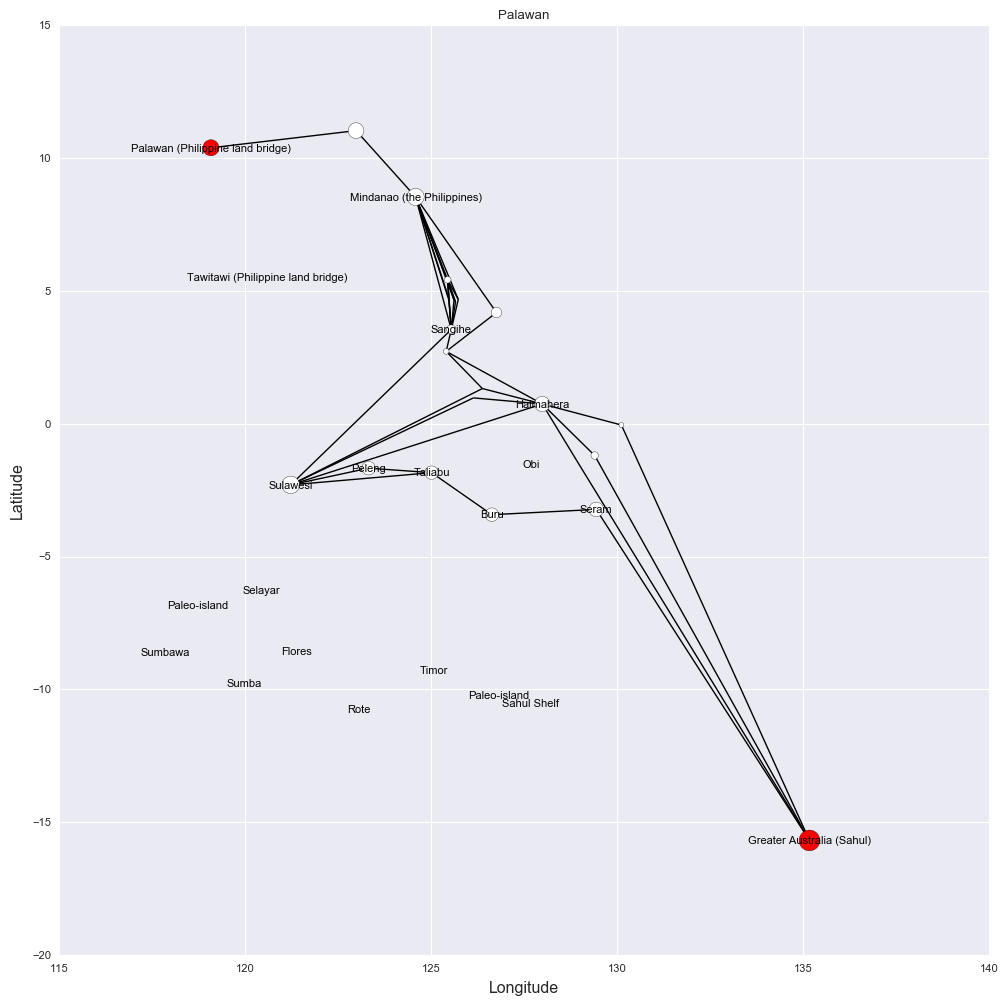

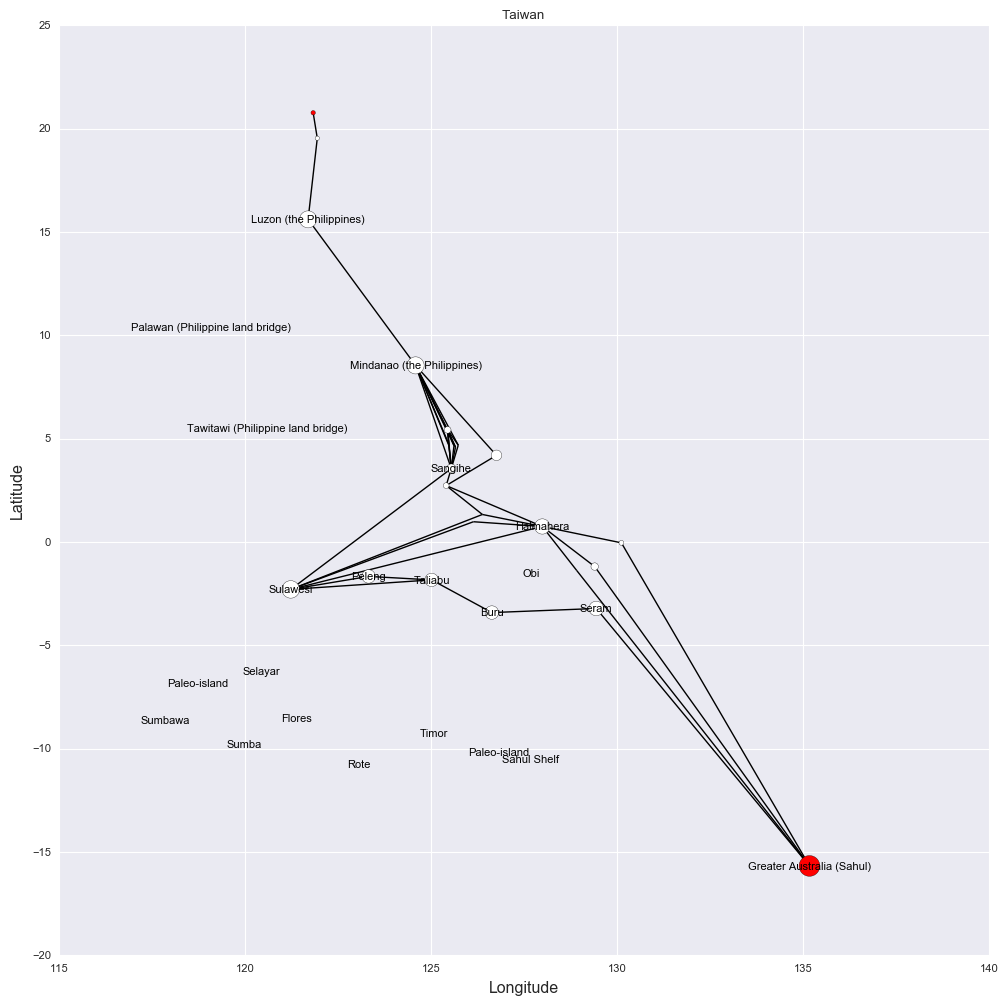

In [305]:
for i, n in ((1933, 'Banda Arc'), (1660, 'Sulawesi'), (1110, 'Tawitawi'), (936, 'Palawan'), (329, 'Taiwan')):
    graph_flow(g, i, name=n)

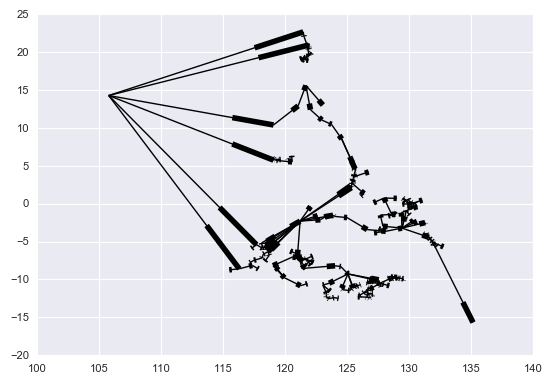

In [169]:
nx.draw_networkx_edges(optimum, pos=pos_dict)

In [12]:
def graph_it(G, name):
    sb.set_context("paper")
    cmap='rainbow'
    fig = plt.figure(num=None, figsize=(12, 12))
    nodelist = G.nodes()
    bc = nx.betweenness_centrality(G, weight='weight')
    
    
    
    min_bc, max_bc = min(bc.itervalues()), max(bc.itervalues())
    mp = (max_bc - min_bc) / 4.0
    # bc = nx.pagerank(G)
    # nx.approximate_current_flow_betweenness_centrality
    # nx.closeness_vitality

    # nx.communicability_betweenness_centrality
    # nx.in_degree_centrality
#     nx.pagerank(G)

    node_colour = [bc[x] for x in nodelist]
    size = [np.log(area_dict[int(x)]) * 20 + 100 for x in nodelist]

    edges = G.edges()
    # colors = [G[u][v]['color'] for u,v in edges]
    weights = [np.log(G[u][v]['traversals']) / 2.0 for u,v in edges]
#     l = {x: str(x) for x in nodelist if area_dict[x] > 0.01}
#     print l.values()


    Z = [[0,0],[0,0]]
    levels = np.linspace(min(bc.values()), max(bc.values()), 100)
    CS3 = plt.contourf(Z, levels, cmap=cmap)
    plt.clf()

    nx.draw_networkx(G, pos=pos_dict, nodelist=nodelist, node_size=size, node_color=node_colour, with_labels=True, cmap=cmap,
                     width=weights, edge_color=weights, edge_cmap=plt.get_cmap('Greys'), arrows=False, 
                     labels=island_labels, font_size='small',)
#     nx.draw_networkx(G, pos=pos_dict, nodelist=nodelist, node_size=size, node_color=node_colour, with_labels=True, cmap=cmap,
#                      width=weights, edge_color=weights, edge_cmap=plt.get_cmap('Greys'), arrows=False, 
#                      labels=l, font_size='small',)

    sb.color_palette()
    plt.colorbar(CS3)
    plt.xlabel('Longitude', fontsize='large')
    plt.ylabel('Latitude', fontsize='large')
    plt.title(labels[name])
    plt.savefig(r'E:\Kasih\Dropbox\2. PNAS\{}_network.pdf'.format(name))

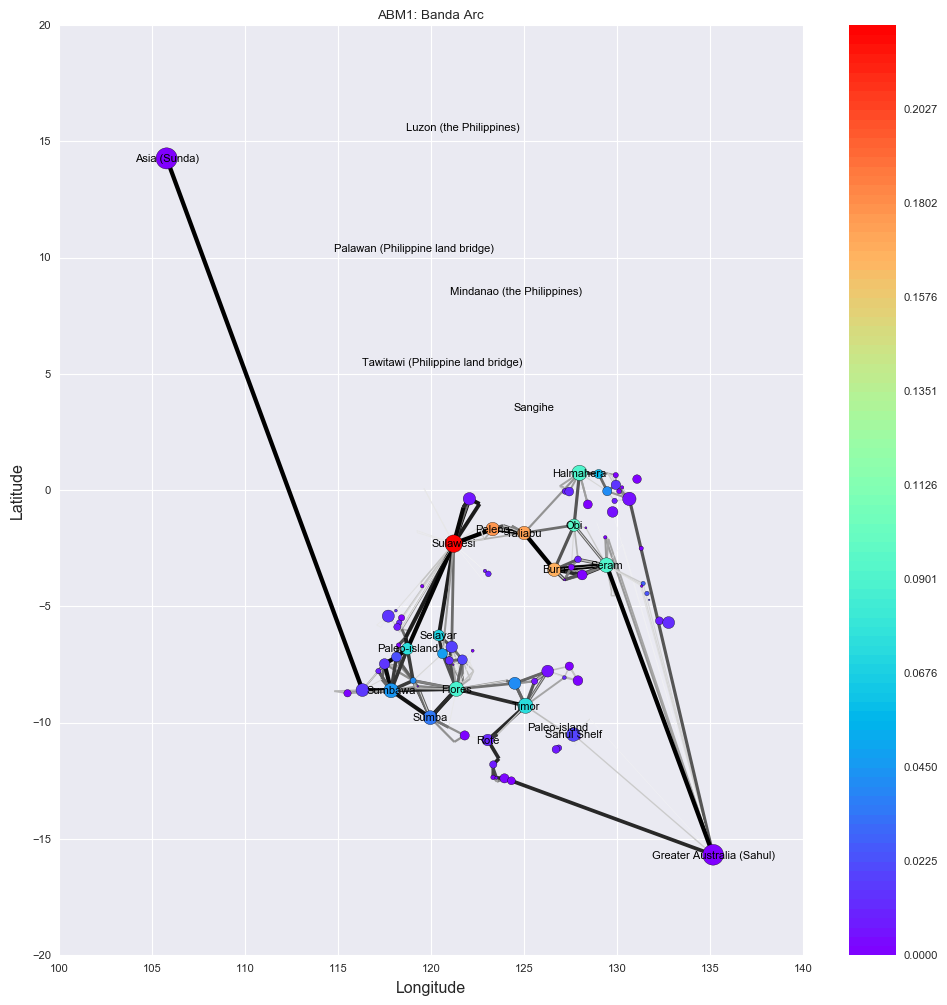

In [16]:
graph_it(networks['south_oft'], 'south_oft')

south_demog
south_palawan_demog
north_palawan_demog
taiwan_south_demog
south_oft
north_demog
demog
taiwan_demog
taiwan_north_demog
palawan_demog
palawan_oft
taiwan_palawan_demog
south_north_demog
north_oft
oft
all_demog


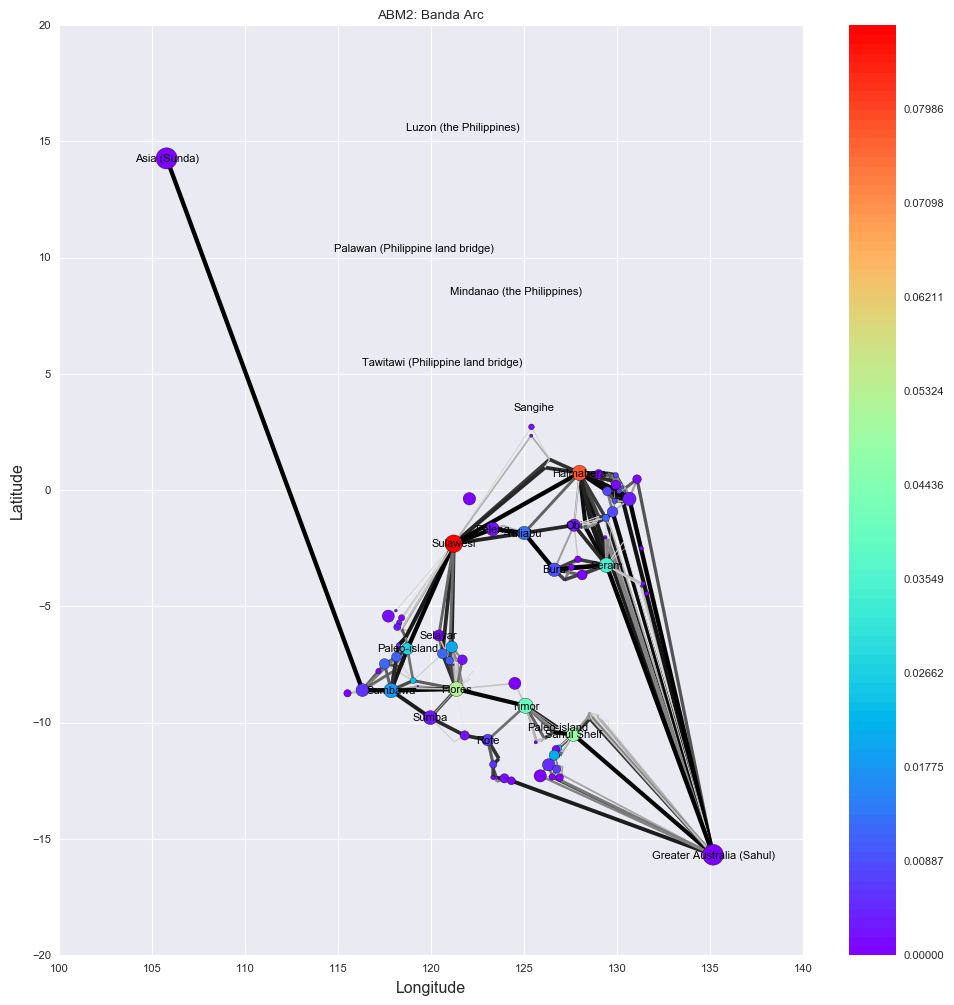

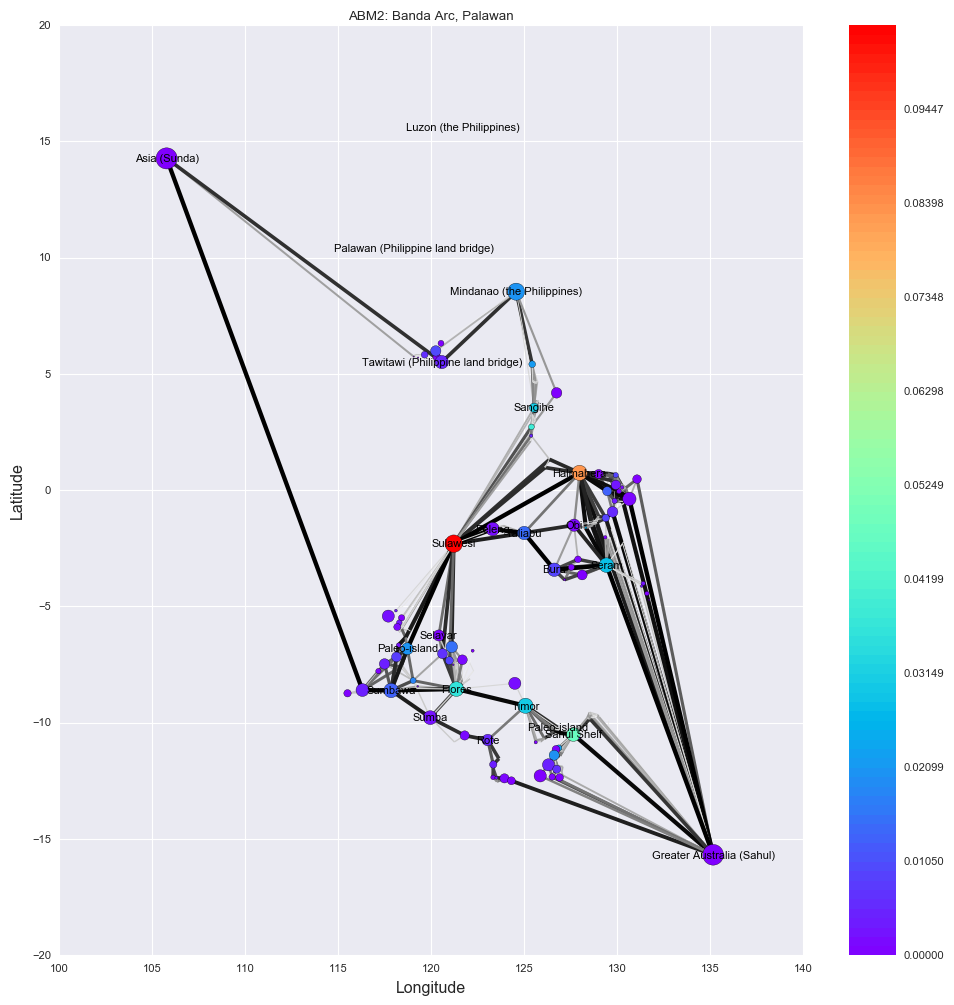

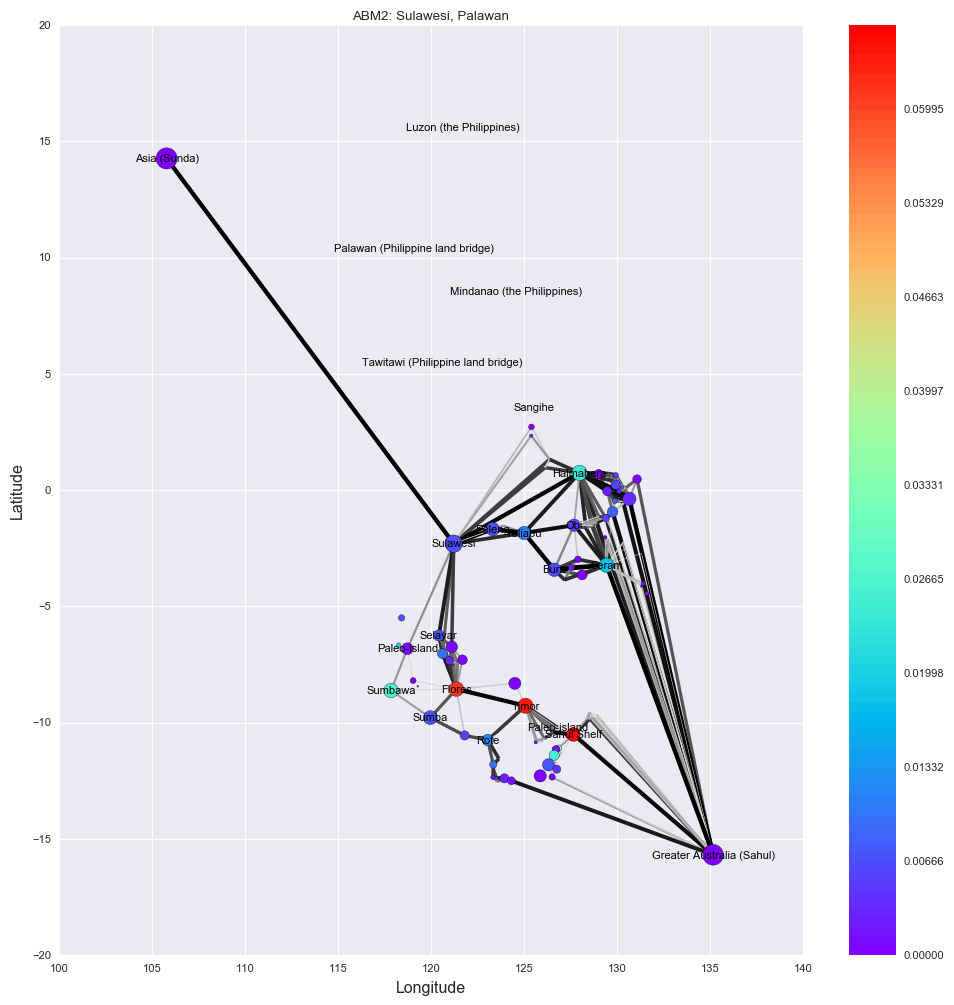

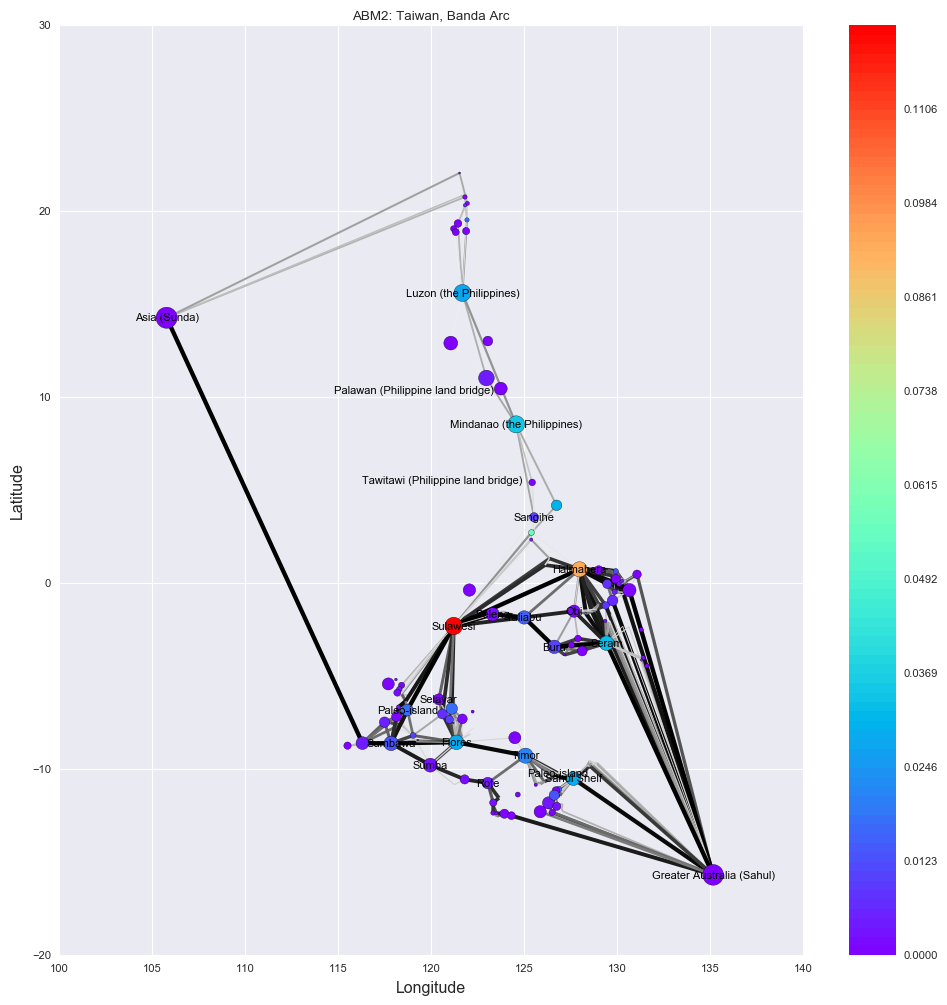

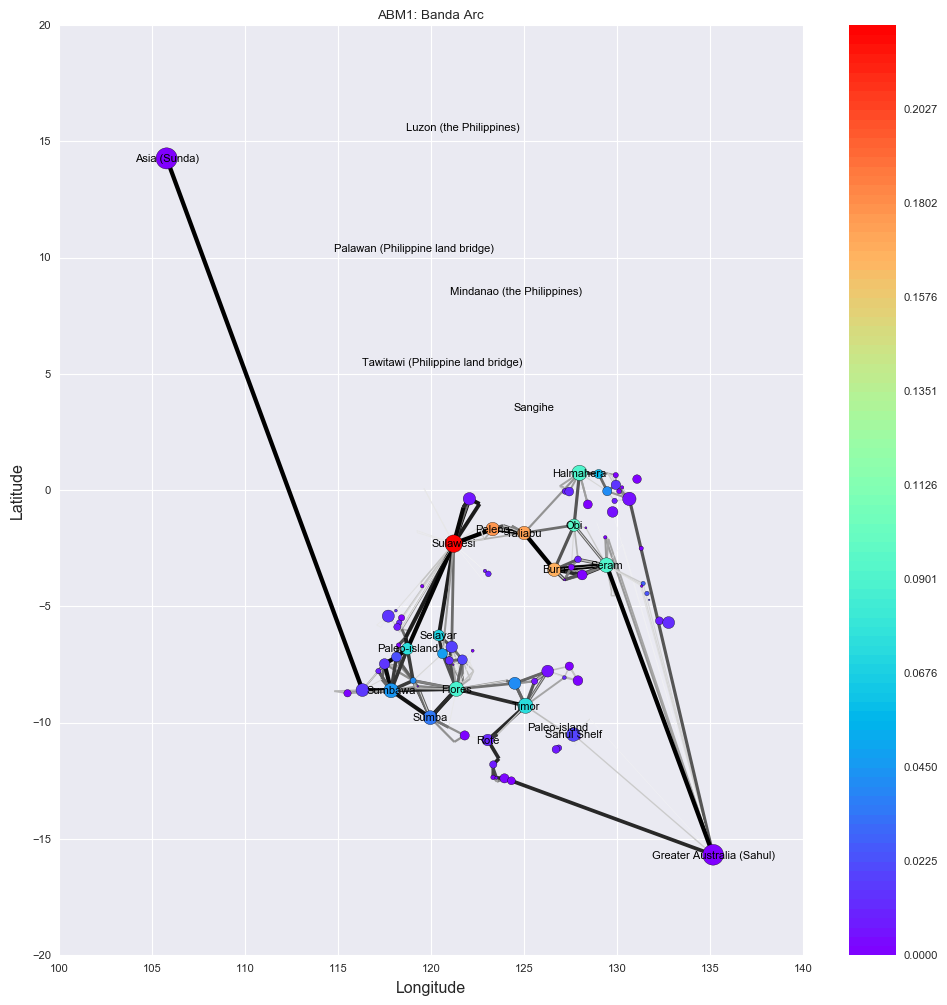

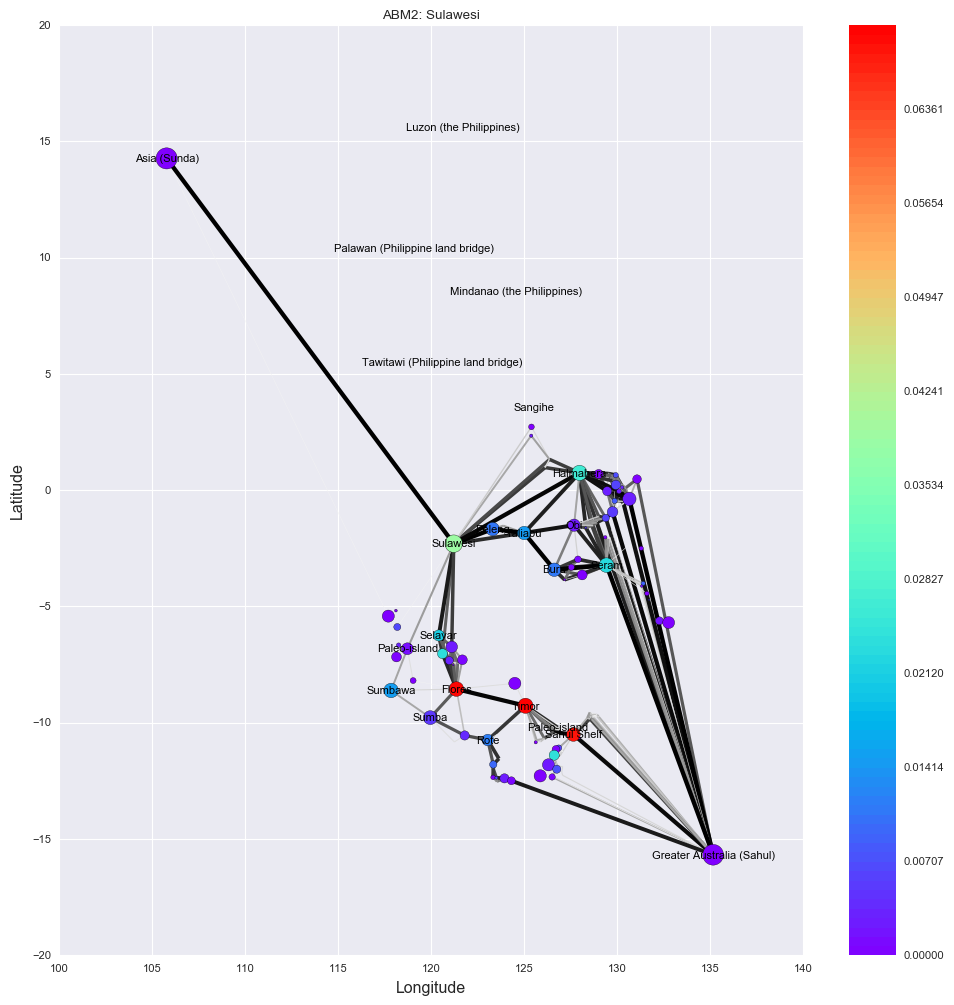

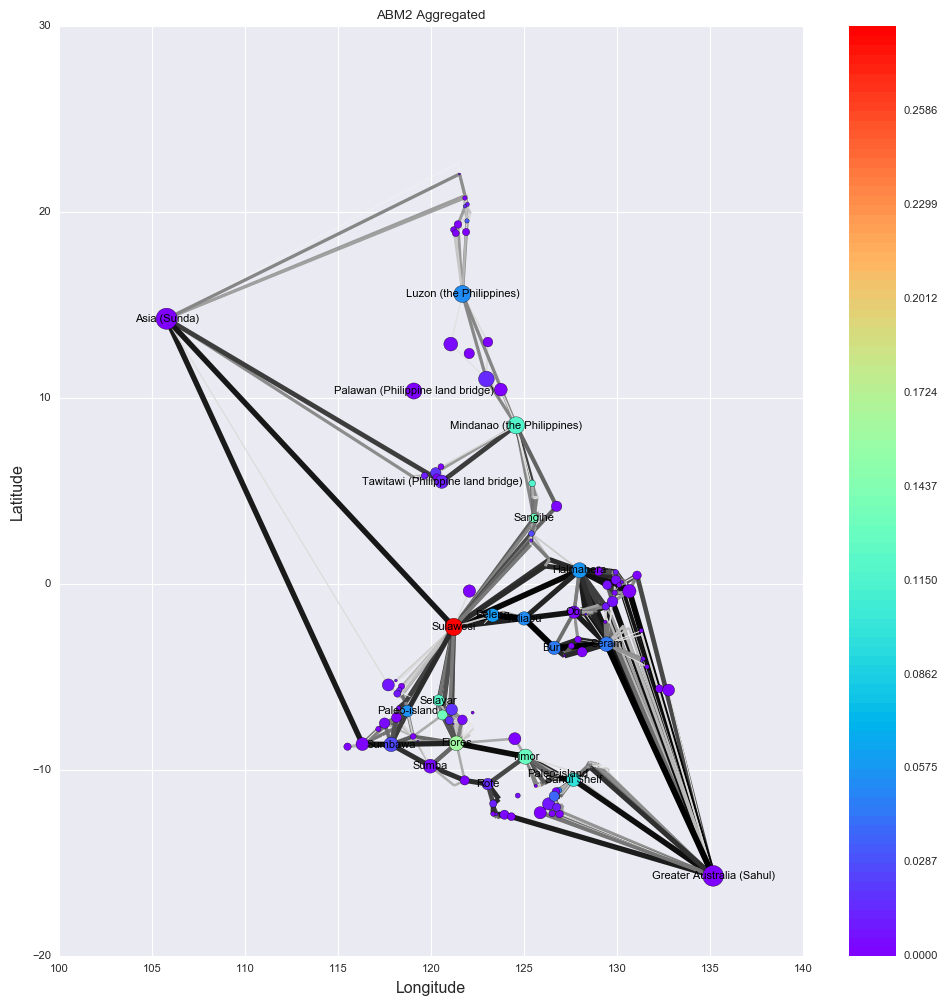

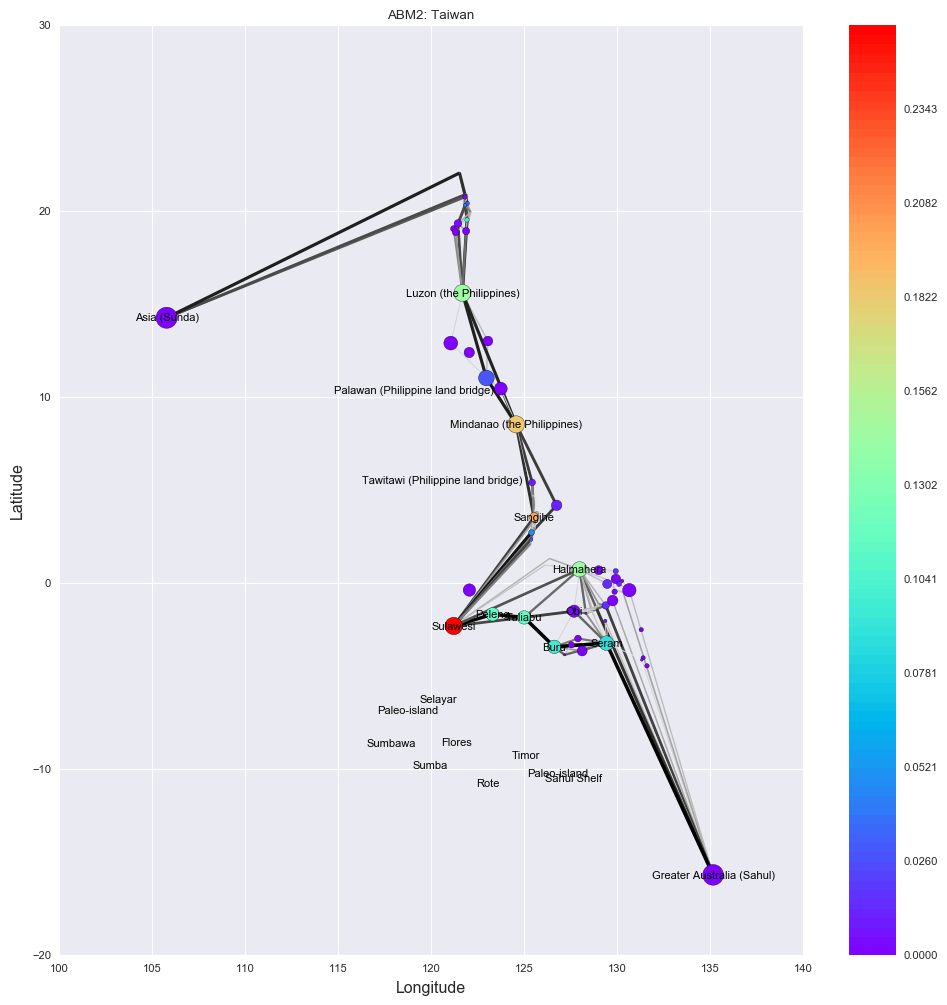

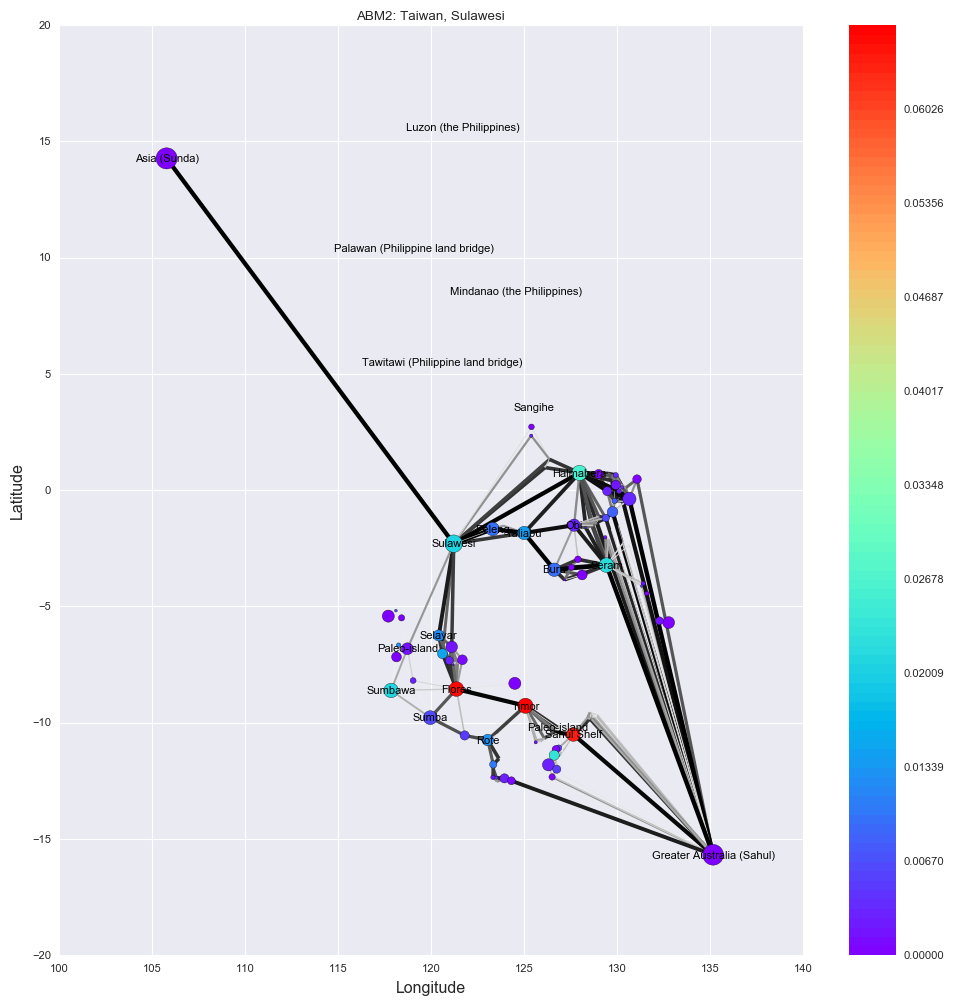

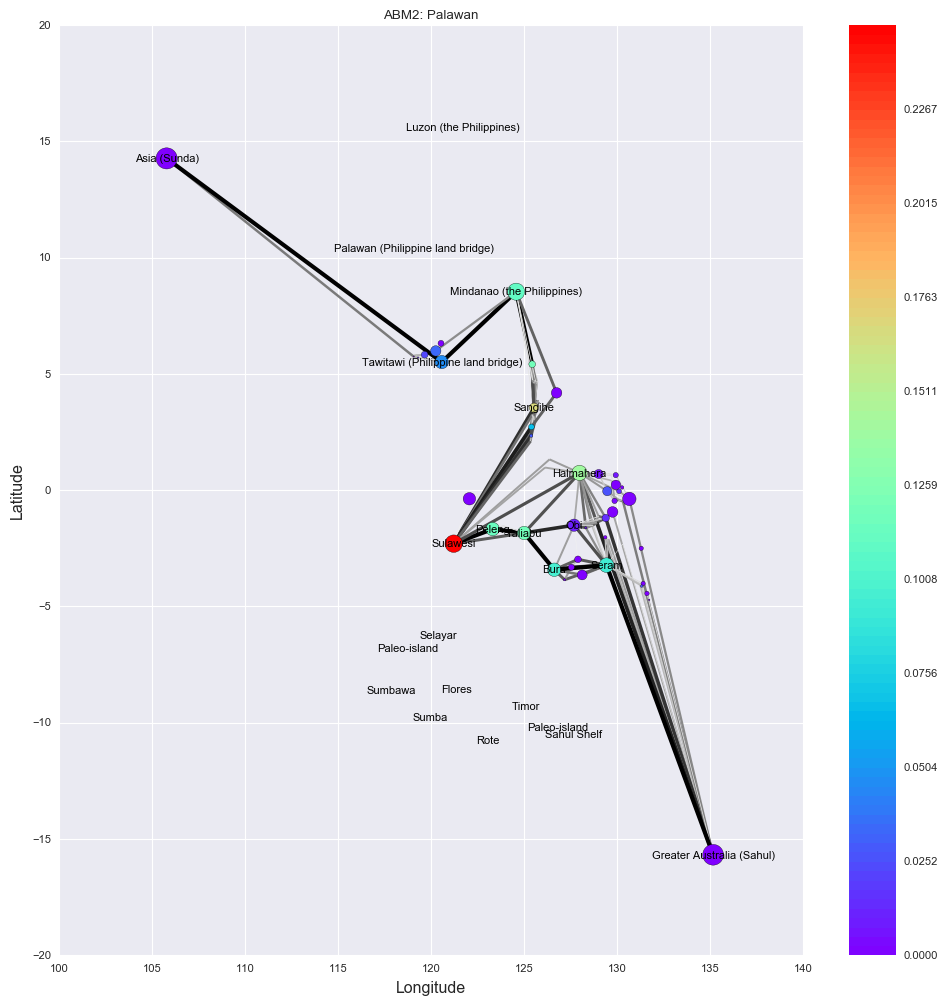

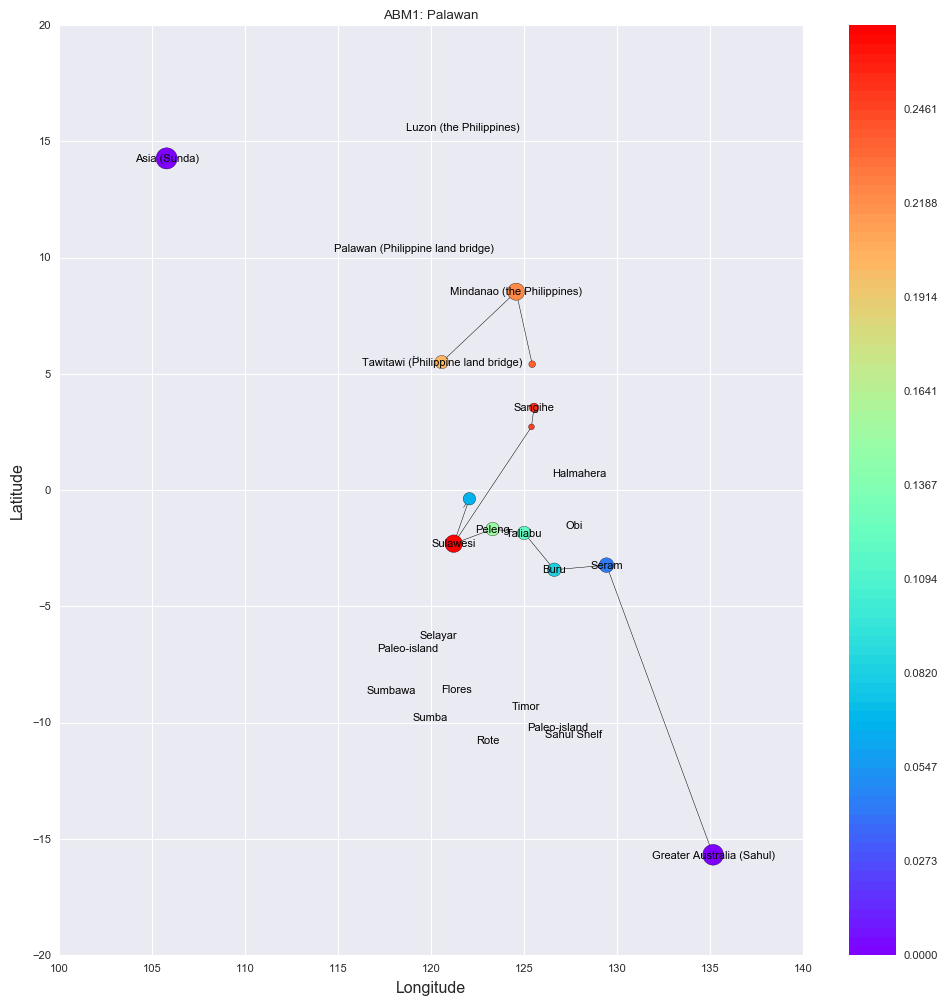

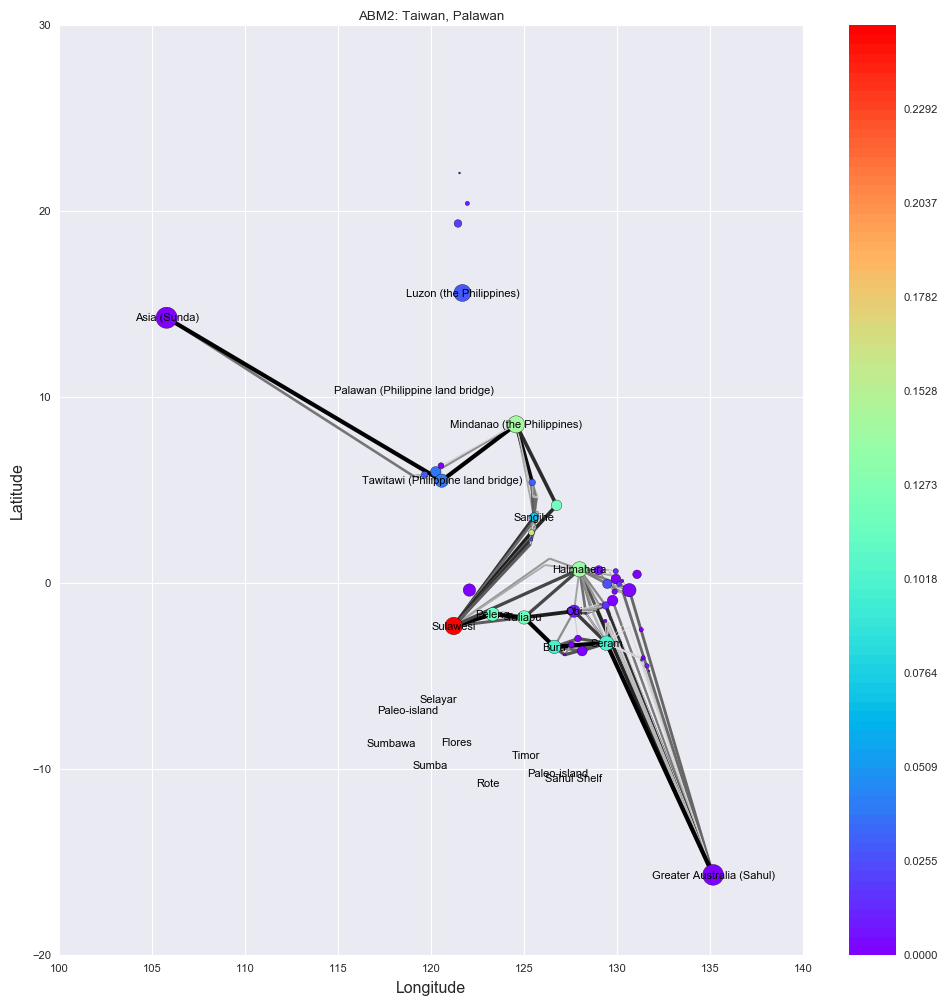

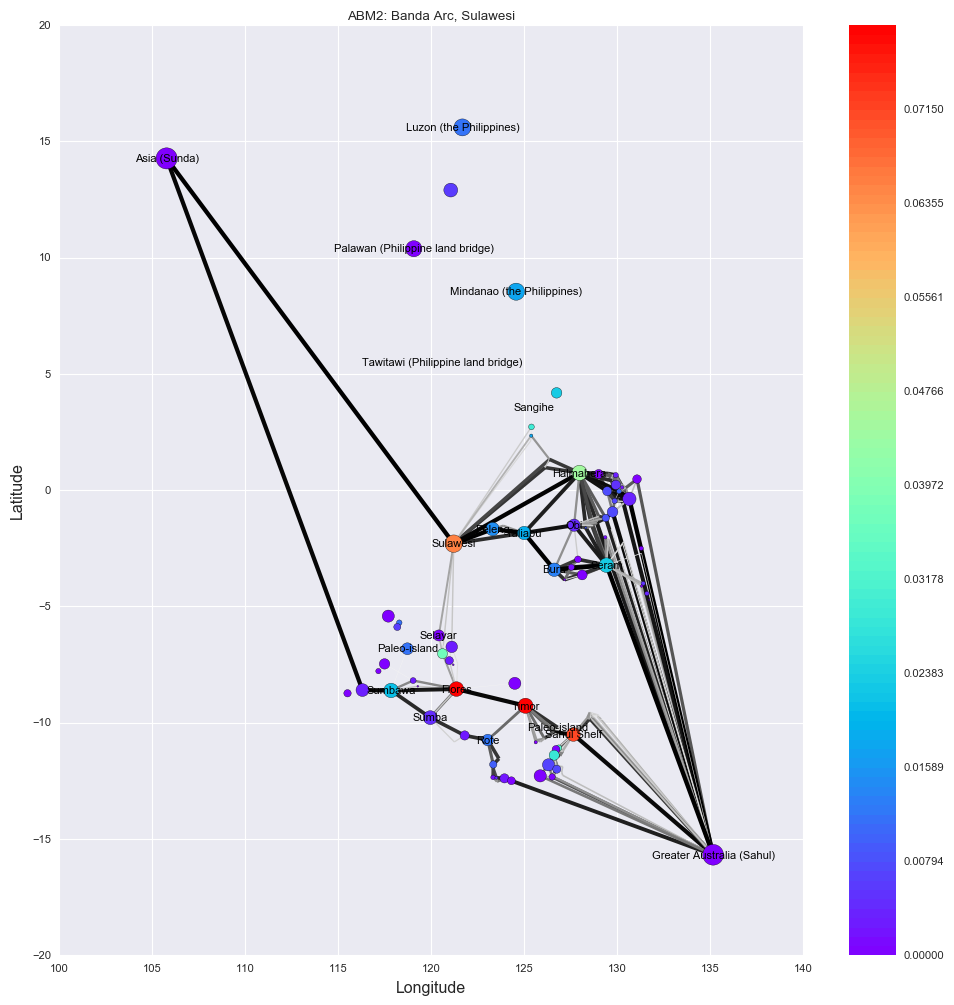

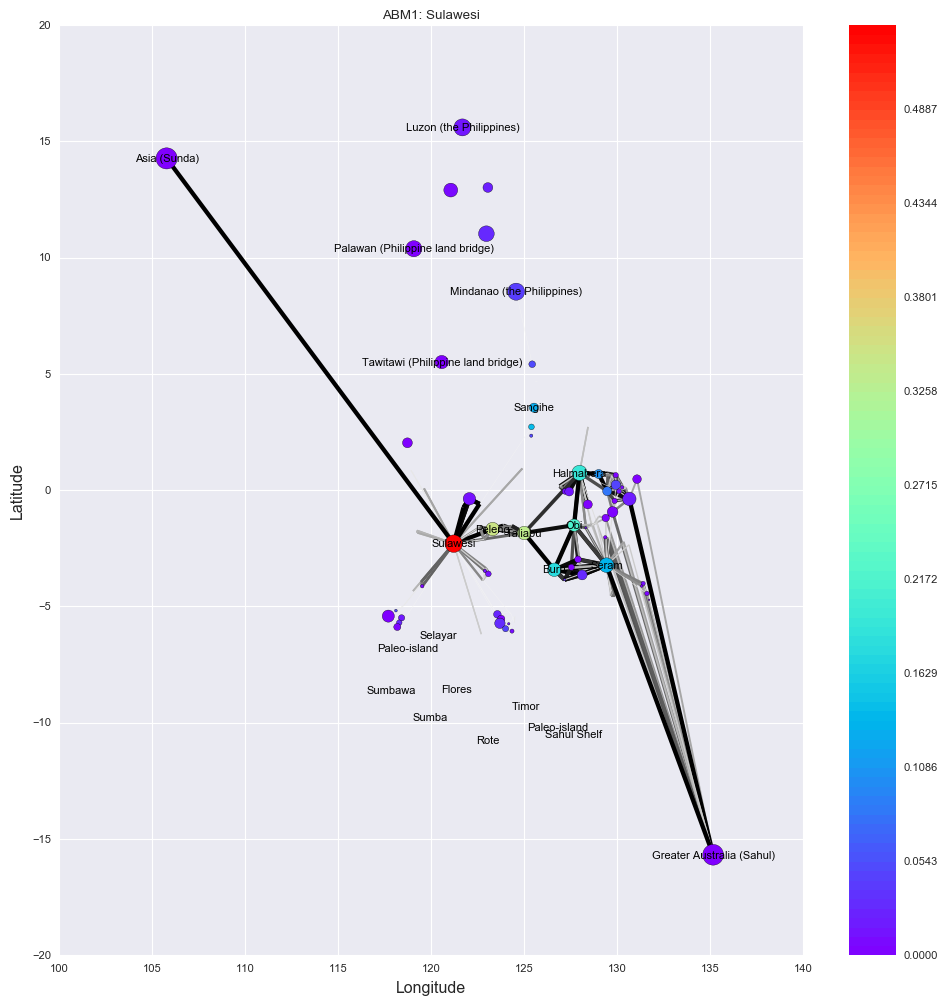

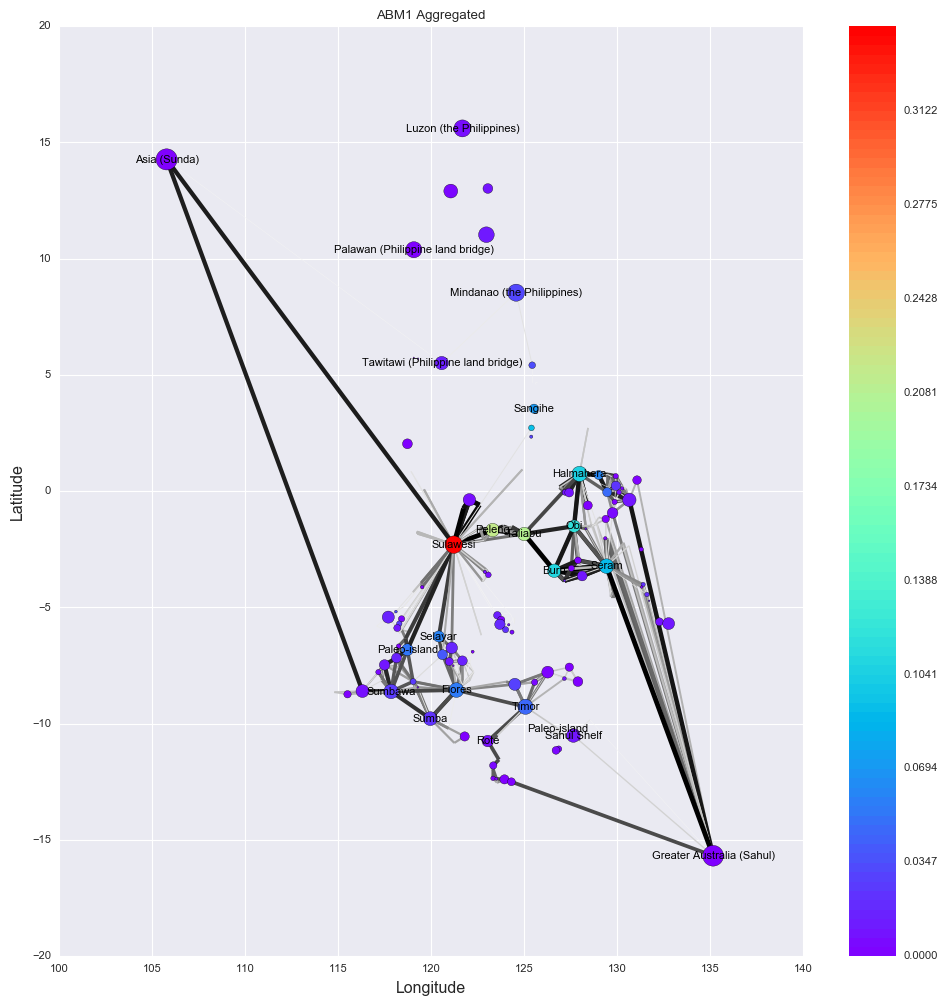

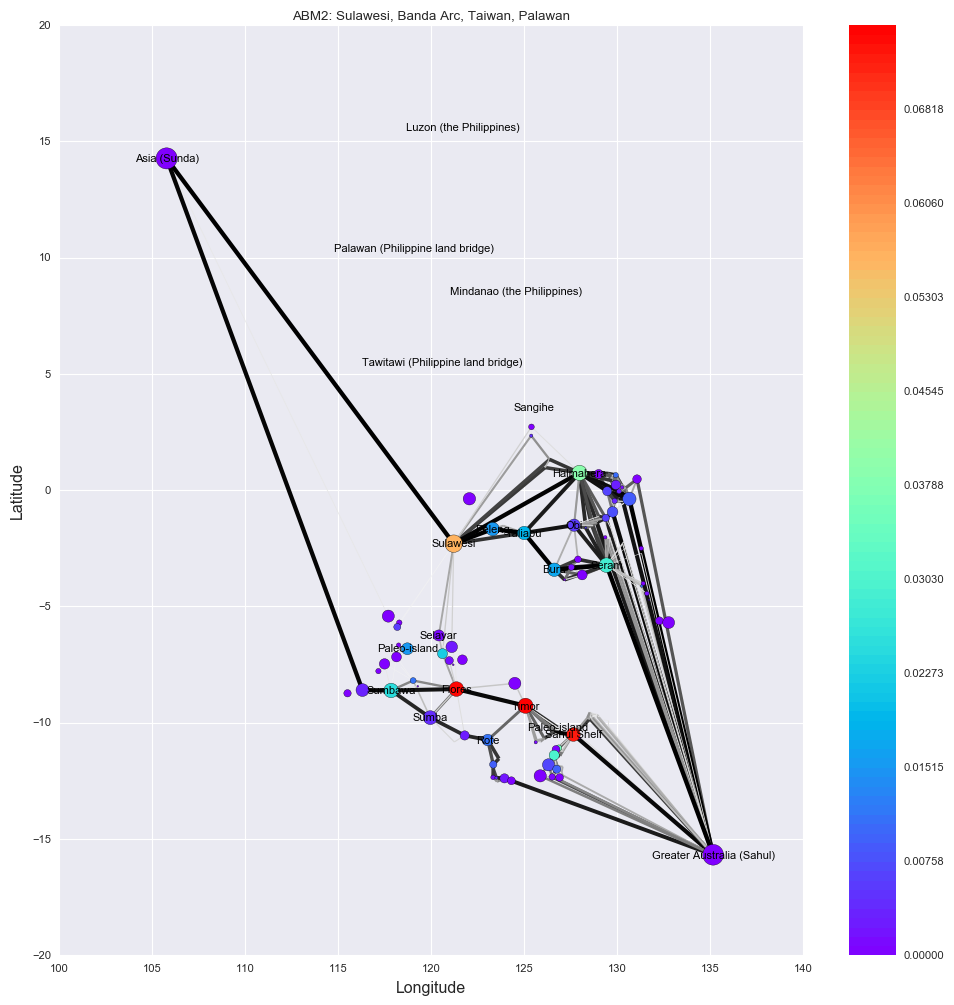

In [17]:
for name, network in networks.iteritems():
    print name
    graph_it(network, name)

In [202]:
sorted(nx.betweenness_centrality(G, weight='weight').iteritems(), key=lambda x:x[1], reverse=True)

[(1660, 0.43717714000842334),
 (1773, 0.2601789536113045),
 (1932, 0.25207575874784044),
 (1212, 0.22766303086563008),
 (1776, 0.18775302338774144),
 (1864, 0.187566076171321),
 (1846, 0.18095201258348162),
 (1815, 0.17640081483200537),
 (1835, 0.1752791315334829),
 (2088, 0.1717335808772337),
 (1829, 0.1717335808772337),
 (1209, 0.16577060931899643),
 (1338, 0.15604290760939635),
 (1400, 0.155643227353601),
 (1347, 0.154495758232124),
 (1529, 0.15305175214666977),
 (1184, 0.1310951239008793),
 (1121, 0.11867280369252985),
 (2052, 0.11626827570201903),
 (2076, 0.11495319873133751),
 (2180, 0.11471467986900802),
 (1432, 0.11465666176736031),
 (1421, 0.11147211263247467),
 (2092, 0.11011835692736134),
 (2104, 0.10891931615997524),
 (1445, 0.1022794667491813),
 (1077, 0.10163482117531782),
 (1523, 0.09738016038781878),
 (1345, 0.08560893220907145),
 (1781, 0.07485624403702844),
 (1280, 0.07065960135117713),
 (816, 0.06384569763544004),
 (837, 0.06091900673009979),
 (1865, 0.05582630669657

In [171]:
o = [1,2,3,4,5,6]
for i in range(len(o)-1):
    print(tuple(o[i:i+2]))

(1, 2)
(2, 3)
(3, 4)
(4, 5)
(5, 6)


In [154]:
x = pd.DataFrame(data=l[1:], columns=l[0])

In [155]:
x.dtypes

run_type        object
run_name        object
populations     object
population      object
entry_island     int64
exit_island      int64
gateway          int64
path_length      int64
dtype: object

In [156]:
x = pd.DataFrame(data=l[1:], columns=l[0])
y = x[['run_type', 'run_name', 'populations', 'population', 'entry_island', 'gateway', 'path_length']].groupby(['run_type', 'run_name', 'populations', 'population', 'entry_island', 'gateway'])
z = y.agg([np.count_nonzero, np.mean, np.std])

In [157]:
z

path_length  \
                                                                                   count_nonzero   
run_type run_name       populations                population entry_island gateway                 
demog    all            north|south|taiwan|palawan north      1650         1                   7   
                                                              1660         1                5604   
                                                                           2                   2   
                                                                           3                  51   
                                                   south      1933         1                   3   
                                                                           3                1119   
         north          north                      north      1650         1                   8   
                                                              1660         1                5553   
                                                                           2                   1   
                                                                           3                 974   
         north_palawan  north|palawan              north      1660         1                5647   
                                                                           3                 997   
         palawan        palawan                    palawan    1059         1                  94   
                                                              1110         1                1399   
         south          south                      south      1933         1                6364   
                                                                           3                1215   
         south_north    south|north                north      936          1                   1   
                                                              1650         1                   2   
                                                              1660         1                5631   
                                                                           3                  70   
                                                   south      1933         1                   3   
                                                                           3                1074   
         south_palawan  south|palawan              palawan    1059         1                  25   
                                                              1110         1                 338   
                                                   south      1933         1                5993   
                                                                           3                1191   
         taiwan         taiwan                     taiwan     300          1                   4   
                                                              305          1                 284   
                                                              326          1                 171   
                                                              329          1                 130   
         taiwan_north   taiwan|north               north      1650         1                   1   
                                                              1660         1                5601   
                                                                           2                   1   
                                                                           3                1031   
         taiwan_palawan taiwan|palawan             palawan    1059         1                 121   
                                                              1110         1                1699   
                                                   taiwan     305          1                   7   
oft      north          north                      north      936          1         

In [158]:
short = z.reset_index()[['run_type', 'gateway', 'path_length']]

In [159]:
short.groupby(['run_type', 'gateway']).sum()

path_length                       
                 count_nonzero        mean        std
run_type gateway                                     
demog    1               44690  263.027099  44.128060
         2                   4   33.500000   0.707107
         3                7722   92.366138  26.487131
oft      1               12368  117.162273   7.000434
         2                   1   22.000000        NaN
         3                 280   16.939286   2.877404

In [165]:
[(x, x / 5000.0 / 10.4832) for x in [44690, 4, 7722]]

[(44690, 0.8526022588522589),
 (4, 7.631257631257631e-05),
 (7722, 0.14732142857142858)]

In [167]:
d = [44690, 4, 7722]
o = [12368, 1, 280]

In [169]:
[float(x) / sum(d) for x in d]

[0.8526022588522588, 7.631257631257631e-05, 0.14732142857142858]

In [164]:
sum([44690, 4, 7722]) / 5000.0

10.4832

In [161]:
sum([12368, 1, 280]) / 2000.0

6.3245

In [166]:
[(x, x / 2000.0 / 6.3245) for x in [12368, 1, 280]]

[(12368, 0.9777848051229348),
 (1, 7.905763301446756e-05),
 (280, 0.022136137244050915)]